# Generative Adversarial Networks - Mode Dropping

One well known problem with GANs is mode dropping - that is when a GAN learns to sample from one part of the target distribution very well, but does not produce samples from other high probability areas. [Unrolled Generative Adversarial Networks](https://openreview.net/pdf?id=BydrOIcle) from ICLR 2017 has a nice easy to grasp visualisation of this, which I reproduce here.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns; sns.set(style="white", color_codes=True)
%matplotlib inline

In [2]:
class Generator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.l1_size = 300
        self.l2_size = 300
        self.l3_size = 150
        self.relu = torch.nn.ReLU()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, self.l3_size)
        self.l4 = torch.nn.Linear(self.l3_size, out_features)
        
    def forward(self,z):
        
        a1 = self.relu(self.l1(z))
        a2 = self.relu(self.l2(a1))
        a3 = self.relu(self.l3(a2))
        a4 = self.l4(a3)
        return a4
    
    
class Discriminator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.l1_size = 300
        self.l2_size = 300
        self.l3_size = 150
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.l1 = torch.nn.Linear(in_features, self.l1_size)
        self.l2 = torch.nn.Linear(self.l1_size, self.l2_size)
        self.l3 = torch.nn.Linear(self.l2_size, self.l3_size)
        self.l4 = torch.nn.Linear(self.l3_size, out_features)
        
    def forward(self, x):
        a1 = self.relu(self.l1(x))
        a2 = self.relu(self.l2(a1))
        a3 = self.relu(self.l3(a2))
        a4 = self.l4(a3)
        return a4
    
    def forward_with_sigmoid(self, x):
        return self.sigmoid(self.forward(x))

In [3]:

x1 = np.random.multivariate_normal(np.array([0,8]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x2 = np.random.multivariate_normal(np.array([0,-8]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x3 = np.random.multivariate_normal(np.array([-8,0]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x4 = np.random.multivariate_normal(np.array([8,0]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x5 = np.random.multivariate_normal(np.array([4,4]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x6 = np.random.multivariate_normal(np.array([-4,-4]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x7 = np.random.multivariate_normal(np.array([-4,4]), np.array([[0.25, 0], [0, 0.25]]), size=200)
x8 = np.random.multivariate_normal(np.array([4,-4]), np.array([[0.25, 0], [0, 0.25]]), size=200)

x_real = np.concatenate([x1, x2, x3, x4, x5, x6, x7, x8], axis=0)

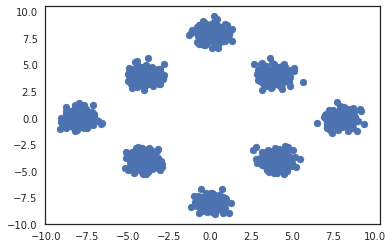

In [4]:
plt.scatter(x_real[:, 0], x_real[:,1])

  0%|          | 0/30000 [00:00<?, ?it/s]

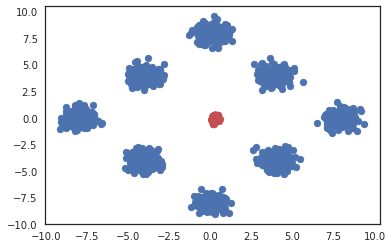

 10%|▉         | 2998/30000 [02:18<20:46, 21.66it/s]

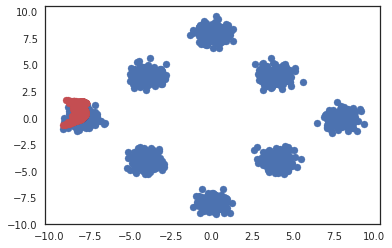

 20%|██        | 6000/30000 [04:38<18:35, 21.52it/s]

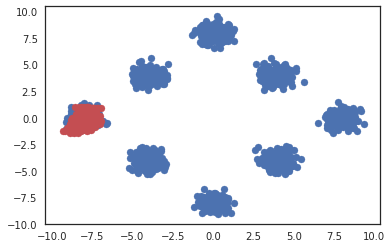

 30%|██▉       | 8999/30000 [06:55<16:09, 21.67it/s]

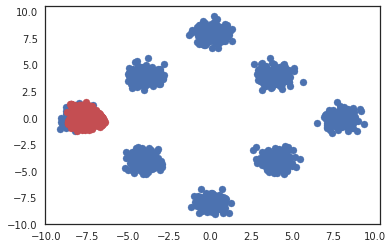

 40%|███▉      | 11998/30000 [09:14<13:51, 21.66it/s]

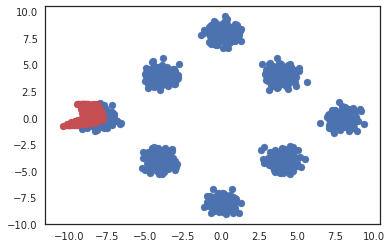

 50%|████▉     | 14999/30000 [11:56<11:56, 20.95it/s]

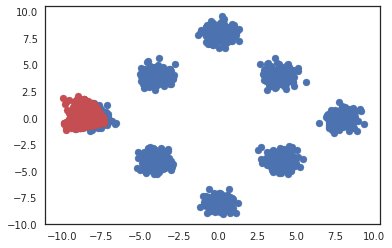

 60%|█████▉    | 17999/30000 [15:09<10:06, 19.79it/s]

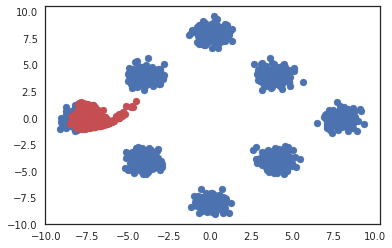

 70%|██████▉   | 20999/30000 [18:34<07:57, 18.84it/s]

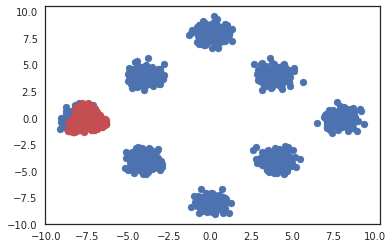

 80%|████████  | 24000/30000 [22:05<05:31, 18.11it/s]

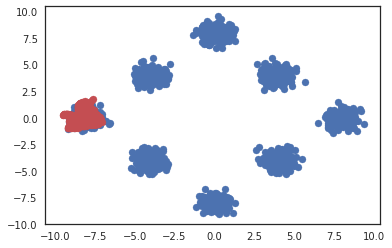

 90%|█████████ | 27000/30000 [25:39<02:51, 17.54it/s]

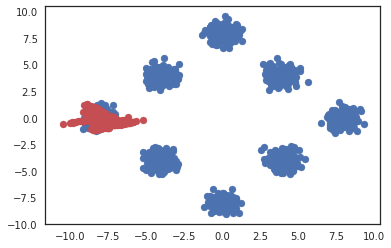

100%|██████████| 30000/30000 [29:15<00:00, 17.09it/s]


In [5]:
G = Generator(2,2)
D = Discriminator(2,1)
G_opt = torch.optim.Adam(G.parameters(), lr=0.001)
D_opt = torch.optim.Adam(D.parameters(), lr=0.001)

x_t_real = torch.from_numpy(x_real).float()

for t in tqdm(range(30000)):
    for i in range(5):
        ind = np.arange(x_real.shape[0])
        mask = np.random.choice(ind, 50)
        x_real_batch = torch.from_numpy(x_real[mask]).float()

        z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
        x_fake = G.forward(z)
        X = torch.cat([x_fake, x_real_batch])
        
        y_hat = D.forward(X)
        
        y = torch.from_numpy(
            np.concatenate([np.zeros((x_real_batch.shape[0],1)), np.ones((x_real_batch.shape[0],1))])).float()
        
        G_opt.zero_grad()
        D_opt.zero_grad()
        Dloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        Dloss.backward()
        D_opt.step()
    
    
    z = torch.from_numpy(np.random.normal(size=x_real_batch.shape)).float()
    x_fake = G.forward(z)
    y_hat = D.forward(x_fake)
    
    D_opt.zero_grad()
    G_opt.zero_grad()
    Gloss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, torch.ones_like(y_hat))
    Gloss.backward()
    G_opt.step()
    
    if t%3000==0:
        z = torch.from_numpy(np.random.normal(size=x_real.shape)).float()
        x_fake = G.forward(z).data.numpy()
        plt.scatter(x_real[:, 0], x_real[:,1])
        plt.scatter(x_fake[:,0], x_fake[:,1], c='r')
        plt.show()

In [11]:
z = torch.from_numpy(np.random.normal(size=(2000,2))).float()
x_fake = G.forward(z).data.numpy()

In [12]:
x_fake[:5]

array([[-7.73088169,  0.22647408],
       [-8.1394434 , -0.03217354],
       [-8.00530052, -0.24134851],
       [-7.49197388, -0.31415343],
       [-8.17405987,  0.46285835]], dtype=float32)

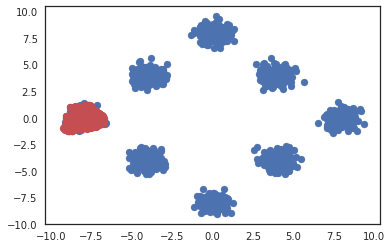

In [13]:
plt.scatter(x_real[:, 0], x_real[:,1])
plt.scatter(x_fake[:,0], x_fake[:,1], c='r')

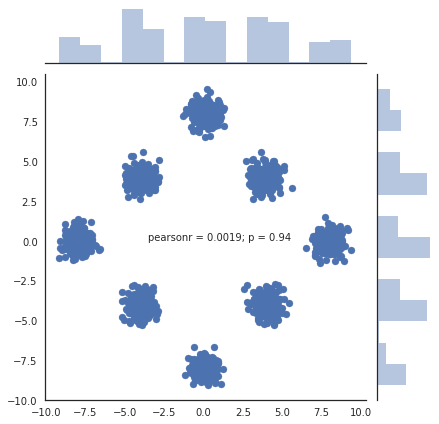

In [14]:
sns.jointplot(x_real[:,0], x_real[:,1])

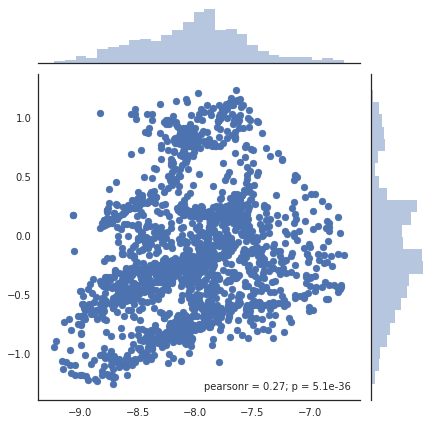

In [15]:
sns.jointplot(x_fake[:,0], x_fake[:,1])

# Summary 

As shown here, Mode dropping is an easy problem to replicate, even on very simple datasets. This suggests it is not a problem of learning or resources, but one that is caused by some part of the formulation of the GAN itself.